In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# pip install jupyter ipython loguru

In [3]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.preproc import get_raw_data
from ARISA_DSML.config import RAW_DATA_DIR, target

2025-05-03 21:04:57.487 | INFO     | ARISA_DSML.config:<module>:12 - PROJ_ROOT path is: C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment


In [4]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [5]:
get_raw_data()
# !dir "{RAW_DATA_DIR}"

2025-05-03 21:04:57.499 | INFO     | ARISA_DSML.preproc:get_raw_data:23 - Downloading dataset mexwell/heart-disease-dataset to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment\data\raw


Dataset URL: https://www.kaggle.com/datasets/mexwell/heart-disease-dataset


2025-05-03 21:04:58.646 | INFO     | ARISA_DSML.preproc:get_raw_data:26 - Download complete.


In [6]:
from ARISA_DSML.preproc import preprocess_df

train_path, test_path = preprocess_df(RAW_DATA_DIR / "heart_statlog_cleveland_hungary_final.csv")

2025-05-03 21:04:58.666 | INFO     | ARISA_DSML.preproc:preprocess_df:61 - Train saved to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment\data\processed\train.csv, Test saved to C:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment\data\processed\test.csv


In [7]:
train_path

WindowsPath('C:/Users/Wojciech/Documents/WWSI/ARISA-MLOps-Assignment/data/processed/train.csv')

In [8]:
import pandas as pd
df_train = pd.read_csv(train_path)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  734 non-null    int64  
 1   sex                  734 non-null    int64  
 2   chest_pain_type      734 non-null    int64  
 3   resting_bp_s         734 non-null    int64  
 4   cholesterol          734 non-null    int64  
 5   fasting_blood_sugar  734 non-null    int64  
 6   resting_ecg          734 non-null    int64  
 7   max_heart_rate       734 non-null    int64  
 8   exercise_angina      734 non-null    int64  
 9   oldpeak              734 non-null    float64
 10  st_slope             734 non-null    int64  
 11  target               734 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 68.9 KB


In [9]:
y_train = df_train.pop(target)
X_train = df_train

In [10]:
from ARISA_DSML.train import run_hyperopt

best_params_path = run_hyperopt(X_train, y_train)

2025-05-03 21:04:59.863 | INFO     | ARISA_DSML.train:run_hyperopt:69 - Best Parameters: {'depth': 6, 'learning_rate': 0.2997467303248517, 'iterations': 258, 'l2_leaf_reg': 29.31565918827504, 'bagging_temperature': 0.5200854166591251, 'random_strength': 0.0057443330613406365}


In [11]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
display(params)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, params, n=n_folds)

{'depth': 6,
 'learning_rate': 0.2997467303248517,
 'iterations': 258,
 'l2_leaf_reg': 29.31565918827504,
 'bagging_temperature': 0.5200854166591251,
 'random_strength': 0.0057443330613406365}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.8792846	test: 0.9047619	best: 0.9047619 (0)	total: 143ms	remaining: 36.9s
1:	learn: 0.8804841	test: 0.8888889	best: 0.9047619 (0)	total: 145ms	remaining: 18.5s
2:	learn: 0.8919330	test: 0.8902439	best: 0.9047619 (0)	total: 146ms	remaining: 12.4s
3:	learn: 0.8933539	test: 0.9079755	best: 0.9079755 (3)	total: 147ms	remaining: 9.34s
4:	learn: 0.9074355	test: 0.9012346	best: 0.9079755 (3)	total: 148ms	remaining: 7.5s
5:	learn: 0.9065850	test: 0.9012346	best: 0.9079755 (3)	total: 149ms	remaining: 6.28s
6:	learn: 0.9040248	test: 0.9000000	best: 0.9079755 (3)	total: 151ms	remaining: 5.4s
7:	learn: 0.9133127	test: 0.9012346	best: 0.9079755 (3)	total: 152ms	remaining: 4.74s
8:	learn: 0.9164087	test: 0.9192547	best: 0.9192547 (8)	total: 153ms	remaining: 4.23s
9:	learn: 0.9214176	test: 0.9125000	best: 0.9192547 (8)	total: 154ms	remaining: 3.82s
10:	learn: 0.9180835	test: 0.8944099	best: 0.9192547 (8)	total: 155ms	remaining: 3.49s
11:	learn: 0.9169231	test: 0.906

In [12]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results,
    name="Mean F1 Score",
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1],
)

In [13]:
plot_error_scatter(
    df_plot=cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)

In [14]:
from ARISA_DSML.train import train
model_path, model_params_path = train(X_train, y_train, params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8727273	total: 1.41ms	remaining: 363ms
50:	learn: 0.9530864	total: 57.5ms	remaining: 233ms
100:	learn: 0.9765142	total: 113ms	remaining: 176ms
150:	learn: 0.9900990	total: 171ms	remaining: 121ms
200:	learn: 0.9937888	total: 227ms	remaining: 64.3ms
250:	learn: 0.9975124	total: 282ms	remaining: 7.88ms
257:	learn: 0.9975124	total: 290ms	remaining: 0us


c:\Users\Wojciech\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



Registered model 'heart-disease-bclass' already exists. Creating a new version of this model...
Created version '3' of model 'heart-disease-bclass'.
c:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment\ARISA_DSML\train.py:176: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages



In [15]:
test_path

WindowsPath('C:/Users/Wojciech/Documents/WWSI/ARISA-MLOps-Assignment/data/processed/test.csv')

In [16]:
df_test = pd.read_csv(test_path)

df_test.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,63,0,2,140,195,0,0,179,0,0.0,1,0
1,53,1,3,145,518,0,0,130,0,0.0,2,1
2,65,1,4,160,0,1,1,122,0,1.2,2,1
3,56,1,4,130,0,0,2,122,1,1.0,2,1
4,54,1,2,108,309,0,0,156,0,0.0,1,0


In [17]:
y_test = df_test.pop(target)
X_test = df_test

In [18]:
df_test.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope
0,63,0,2,140,195,0,0,179,0,0.0,1
1,53,1,3,145,518,0,0,130,0,0.0,2
2,65,1,4,160,0,1,1,122,0,1.2,2
3,56,1,4,130,0,0,2,122,1,1.0,2
4,54,1,2,108,309,0,0,156,0,0.0,1


In [19]:
df_train.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope
0,42,1,3,120,240,1,0,194,0,0.8,3
1,36,1,3,130,209,0,0,178,0,0.0,1
2,56,1,4,150,213,1,0,125,1,1.0,2
3,37,0,3,130,211,0,0,142,0,0.0,1
4,51,1,4,120,0,1,0,104,0,0.0,2


{'depth': 6,
 'learning_rate': 0.2997467303248517,
 'iterations': 258,
 'l2_leaf_reg': 29.31565918827504,
 'bagging_temperature': 0.5200854166591251,
 'random_strength': 0.0057443330613406365,
 'eval_metric': 'F1',
 'loss_function': 'Logloss',
 'feature_columns': ['age',
  'sex',
  'chest_pain_type',
  'resting_bp_s',
  'cholesterol',
  'fasting_blood_sugar',
  'resting_ecg',
  'max_heart_rate',
  'exercise_angina',
  'oldpeak',
  'st_slope'],
 'ignored_features': [0]}

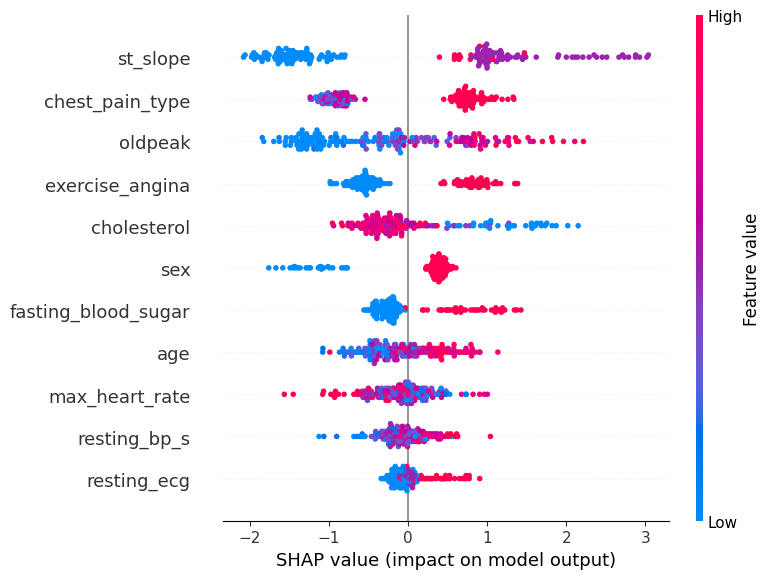

In [20]:
from ARISA_DSML.predict import predict
from catboost import CatBoostClassifier

params = joblib.load(model_params_path)
display(params)
from_file = CatBoostClassifier()
model = from_file.load_model(str(model_path))
preds_path = predict(model, df_test, params)